In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.ndimage as ndimage
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.cm as cm
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score

In [98]:
X_train = pd.read_csv("../coursework/x_train_all.csv")
X_test = pd.read_csv("../coursework/x_test_all.csv")
y_train = pd.read_csv("../coursework/y_train_all.csv")
y_test = pd.read_csv("../coursework/y_test_all.csv")

# Image processing
Based of the previous submission demo, we have decided to try modifying some preprocessing steps, which includes trying different image manipulation algorithms along with feature selection to obtain a greater accuracy using a simple classifier.

In [54]:
image_size = (48, 48)

def plot_images(instances, images_per_row=5, **options):
    size = 48
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size).T for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, interpolation='nearest', cmap=cm.Greys_r, **options)
    plt.axis("off")

Image processing here first using a form of histogram equalization called Contrast Limited Adaptive Histogram Equalization or CLAHE. It is then followed by applying a small median filter to denoise the image.

In [55]:
def process_images_a(dataframe):
    processed_images = []

    for index, row in dataframe.iterrows():
        pixel_values = row.values

        processed_image = np.reshape(pixel_values, image_size).astype(np.uint8)
        
        clahe = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(8, 8))
        processed_image = clahe.apply(processed_image)
        processed_image = ndimage.median_filter(processed_image, size=2)
        
        # Append the processed image to the list
        processed_images.append(processed_image.flatten())
    
    df = pd.concat([pd.DataFrame(sublist) for sublist in processed_images], axis=1)
    df.columns=[str(i) for i in range(0, len(processed_images))]
    
    return df.T

processed_df_a = process_images_a(X_train)

Image processing here uses Histogram Equalization to increase the image contrast, followed by applying a 3x3 gaussian blur with sigma=3 and then using the CLAHE equalization

In [56]:
def process_images_b(dataframe):
    processed_images = []

    for index, row in dataframe.iterrows():
        pixel_values = row.values

        processed_image = np.reshape(pixel_values, image_size).astype(np.uint8)
        
        processed_image = cv2.equalizeHist(processed_image)
        processed_image = cv2.GaussianBlur(processed_image,(3,3), 3)
        
        clahe = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(4, 4))
        processed_image = clahe.apply(processed_image)

        # Append the processed image to the list
        processed_images.append(processed_image.flatten())
    
    df = pd.concat([pd.DataFrame(sublist) for sublist in processed_images], axis=1)
    df.columns=[str(i) for i in range(0, len(processed_images))]
    
    return df.T

processed_df_b = process_images_b(X_train)

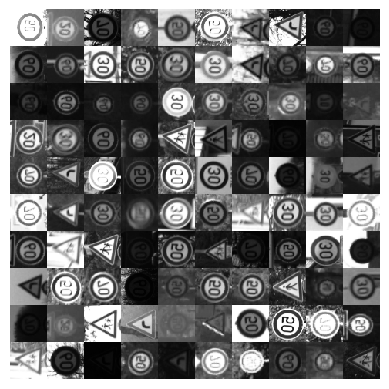

In [57]:
df_original = X_train.to_numpy(); 
df_a = processed_df_a.to_numpy();  
df_b = processed_df_b.to_numpy();  

random_indices = np.random.choice(df_original.shape[0], size=100, replace=False)

images_original = df_original[random_indices, :]
images_a = df_a[random_indices, :]
images_b = df_b[random_indices, :]

plot_images(images_original, images_per_row=10)

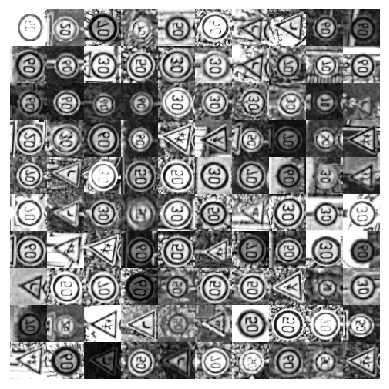

In [58]:
plot_images(images_a, images_per_row=10)

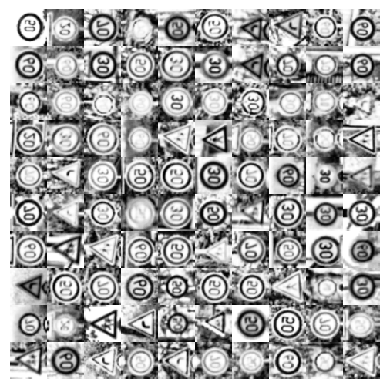

In [59]:
plot_images(images_b, images_per_row=10)

In [60]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif

def selectFTest(top_features, x_train_arg, y_train_arg):
    selected_features = []

    for y_class in range(10):
        selector = SelectKBest(score_func=f_classif, k=top_features)
        selector.fit(x_train_arg, (y_train_arg.values.ravel() == y_class).astype(int))
        selected_indices = selector.get_support(indices=True)
        selected_features.extend(selected_indices)

    return x_train_arg.iloc[:, selected_features]

df_compare_1 = selectFTest(10, X_train, y_train) # 50 features
df_compare_2 = selectFTest(10, processed_df_a, y_train) # 100 features
df_compare_3 = selectFTest(10, processed_df_b, y_train) # 200 features

In [61]:
labels = [0,1,2,3,4,5,6,7,8,9]
label_names = ['0','1','2','3','4','5','6','7','8','9']

def each_cat_eval(conf_matrix):
    FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  
    FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
    TP = np.diag(conf_matrix)
    TN = conf_matrix.sum() - (FP + FN + TP)
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    
    d = {'Recall': TPR, 'TNR': TNR, 'Precision':PPV, 'NPV': NPV, 'FPR':FPR, 'FNR':FNR,'FDR':FDR, 'ACC':ACC}
    df = pd.DataFrame(data=d)
    print("Against each category\n", df)

    
    return TPR, TNR, PPV, NPV, FPR, FNR, FDR, ACC

def plot_confusion_matrix(matrix,labels=labels):
    disp_plot = ConfusionMatrixDisplay(matrix, display_labels=labels)
    disp_plot.plot();

D:\Applications\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Applications\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Applications\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Applications\Anaconda\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


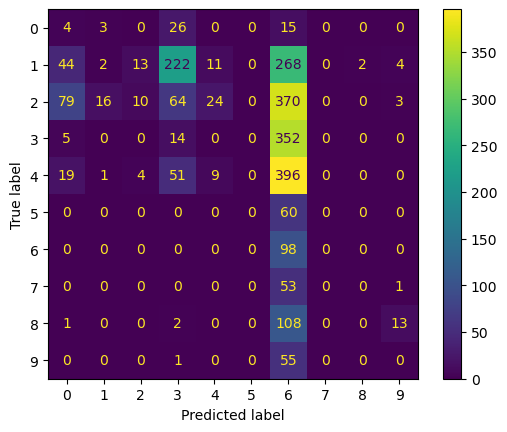

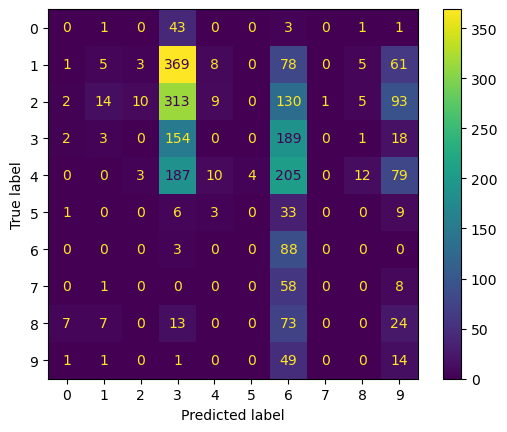

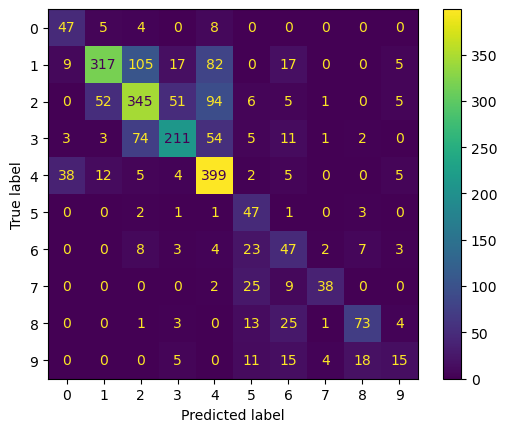

In [62]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

# Build a Gaussian Classifier
model = GaussianNB()

# Model testing
x_train_1, x_test_1, y_train_1, y_test_1, = train_test_split(df_compare_1, y_train, test_size=0.25)
x_train_2, x_test_2, y_train_2, y_test_2, = train_test_split(df_compare_2, y_train, test_size=0.25)
x_train_3, x_test_3, y_train_3, y_test_3, = train_test_split(df_compare_3, y_train, test_size=0.25)

model.fit(x_train_1 , y_train_1)
model.fit(x_train_2 , y_train_2)
model.fit(x_train_3 , y_train_3)

y_pred_1 = model.predict(x_test_1)
y_pred_2 = model.predict(x_test_2)
y_pred_3 = model.predict(x_test_3)

confusion_matrix_1 = confusion_matrix(y_test_1, y_pred_1, labels=labels)
confusion_matrix_2 = confusion_matrix(y_test_2, y_pred_2, labels=labels)
confusion_matrix_3 = confusion_matrix(y_test_3, y_pred_3, labels=labels)

plot_confusion_matrix(confusion_matrix_1);
plot_confusion_matrix(confusion_matrix_2);
plot_confusion_matrix(confusion_matrix_3);

We can compare the performance of the first confusion matrix with the last and see that by applying certain image processing methods, there is an increase in performance of Naive Bayes classifier.

# Count of each category instance in the training dataset

In [63]:
value_counts = y_train.value_counts()
value_counts

0
2    2250
1    2220
4    1980
3    1410
8     540
6     360
9     270
7     240
0     210
5     210
dtype: int64

<Axes: ylabel='0'>

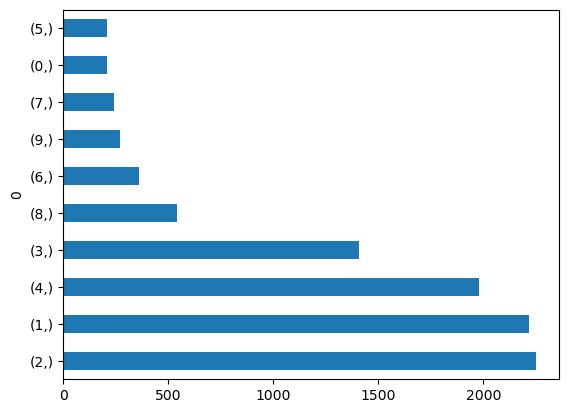

In [64]:
value_counts.plot(kind='barh')

In [117]:
X_train = processed_df_b
X_train.reset_index(drop=True, inplace=True)

X_test = process_images_b(X_test)
X_test.reset_index(drop=True, inplace=True)

# Balance the Dataset

We see that the data is imbalanced. So we balance it so that each class has similar number of rows.

In [119]:
y_train.columns = ['Class']

concatenated = pd.concat([X_train, y_train.rename(columns={0: "Output"})], axis="columns")
concatenated.head()

,0,1,2,3,4,5,6,7,8,9,...,2295,2296,2297,2298,2299,2300,2301,2302,2303,Class
0,19,16,23,44,71,103,152,177,177,162,...,30,19,39,92,135,163,170,161,156,0
1,21,30,37,42,41,58,94,154,177,157,...,100,71,31,9,28,89,135,165,170,0
2,18,23,30,42,69,103,131,111,89,99,...,119,100,61,21,11,25,74,119,135,0
3,7,12,25,57,104,133,131,74,71,125,...,134,111,89,55,23,16,37,80,101,0
4,23,23,25,37,62,113,138,124,92,79,...,116,123,130,120,96,53,18,11,12,0


Helper function to aid in upsampling of classes

In [120]:
def resample_42(li):
    return resample(li, 
         replace=True,    # sample with replacement
         n_samples= 2250, # to match majority class
         random_state=42) # reproducible results

In [121]:
# Create two different dataframe of majority and minority class 
df_balanced = []

df_class_2 = concatenated[(concatenated['Class']==2)]

for i in range(10):
    balanced = concatenated[(concatenated['Class'] == i)]
    if i != 2:
        balanced = resample_42(balanced) # resample using a predefined state
    df_balanced.append(balanced)
    
result = pd.concat(df_balanced)
result.head()

,0,1,2,3,4,5,6,7,8,9,...,2295,2296,2297,2298,2299,2300,2301,2302,2303,Class
102,5,9,12,14,16,19,21,24,26,27,...,163,135,115,94,81,83,99,124,133,0
179,73,73,62,66,66,62,46,35,29,40,...,190,200,204,205,197,191,191,195,195,0
92,7,5,5,7,12,18,27,38,48,54,...,172,174,173,177,159,120,83,46,28,0
14,198,182,117,64,76,151,212,240,250,254,...,88,107,114,103,103,129,163,197,207,0
106,5,9,14,19,27,28,28,26,19,16,...,153,128,103,78,67,58,62,74,80,0


# Count of each category instance in the training dataset after balancing

In [122]:
y_train_upsampled =result["Class"]
y_train_upsampled.value_counts()

0    2250
1    2250
2    2250
3    2250
4    2250
5    2250
6    2250
7    2250
8    2250
9    2250
Name: Class, dtype: int64

# KMeans clustering

In [123]:
kmeans_1 = KMeans(n_clusters=10, random_state=42)
y_pred_1 = kmeans_1.fit_predict(X_train)
y_pred_1

D:\Applications\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([3, 3, 3, ..., 3, 3, 3])

In [124]:
y_pred_1 is kmeans_1.labels_

True

In [125]:
kmeans_1.cluster_centers_

array([[209.03120567, 209.52198582, 211.4964539 , ...,  96.3106383 ,
         97.15602837,  97.91347518],
       [145.73047619, 147.08285714, 150.18190476, ...,  77.46857143,
         78.39428571,  78.36095238],
       [219.65238095, 220.39047619, 222.53809524, ..., 149.55      ,
        150.14047619, 150.29047619],
       ...,
       [134.1112277 , 134.01364113, 133.37565582, ..., 118.96117524,
        118.55823715, 118.73557188],
       [119.55490483, 119.0885798 , 116.69399707, ...,  83.74450952,
         82.30673499,  81.45241581],
       [197.64454976, 196.89691943, 194.78436019, ..., 160.20853081,
        159.39099526, 159.07701422]])

In [126]:
kmeans_1.cluster_centers_.shape

(10, 2304)

# Showing the classes belonging to each cluster

We are mapping the number of instances of each cluster to how many classes it contains. Ideally each cluster should have only instances that belong to one class.

In [127]:
image_cluster_1 = pd.DataFrame(y_train,columns=['Class'])
image_cluster_1['clusterid'] = y_pred_1
image_cluster_1

,Class,clusterid
0,0,3
1,0,3
2,0,3
3,0,3
4,0,3
...,...,...
9685,9,3
9686,9,3
9687,9,3
9688,9,3


In [128]:
def mapping_cluster_to_classes(n_range, cluster, cols, cluster_labels):
    data = []
    for clusterId in range(n_range):
        clusterRows = cluster.loc[cluster['clusterid'] == clusterId]
        clusterRows = clusterRows.drop(["clusterid"], axis=1)
        value_counts = clusterRows.value_counts()
        count_arr = []
        for i in range(n_range):
            class_count = clusterRows.value_counts().get(i, 0)
            count_arr.append(class_count)
        data.append(count_arr)  
    print("data \n")    
    df = pd.DataFrame(data, index=cluster_labels, columns=cols)  
    print(df)

clusterLabels = [f'Cluster {i}' for i in range(10)]
cols = [f'Class {i}' for i in range(10)]

mapping_cluster_to_classes(10, image_cluster_1, cols, clusterLabels)

data 

           Class 0  Class 1  Class 2  Class 3  Class 4  Class 5  Class 6  \
Cluster 0        7      134       98      190      167        3       31   
Cluster 1       18      157      329      163      354        7       13   
Cluster 2        0       50       26      136       12        4       69   
Cluster 3       28      262      127       84       99        2       35   
Cluster 4       39      232      268      103      108        3       45   
Cluster 5        2       10       11        9        5      190      167   
Cluster 6        0      289      571      246      576        1        0   
Cluster 7       22      429      220      100      182        0        0   
Cluster 8       29      360      444      176      356        0        0   
Cluster 9       65      297      156      203      121        0        0   

           Class 7  Class 8  Class 9  
Cluster 0       32       10       33  
Cluster 1        2        3        4  
Cluster 2        5       81       37  


# Scatter plot of centroids

We show the centroids of just two features on a 2-D plane.

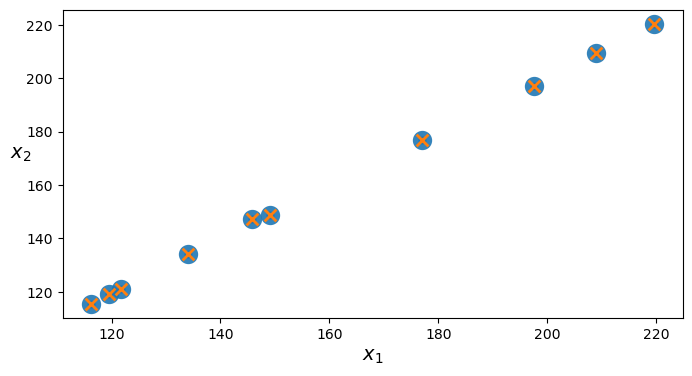

In [129]:
def plot_centroids(centroids, weights=None):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                 zorder=11, alpha=1)

    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.figure(figsize=(8, 4))
plot_centroids(kmeans_1.cluster_centers_)
plt.show()

We show the scatter plot of centroids of all the features. We see that some points are intersecting. This shows that K-Means will be confused while classification. The best value is when all clusters are completely separated.


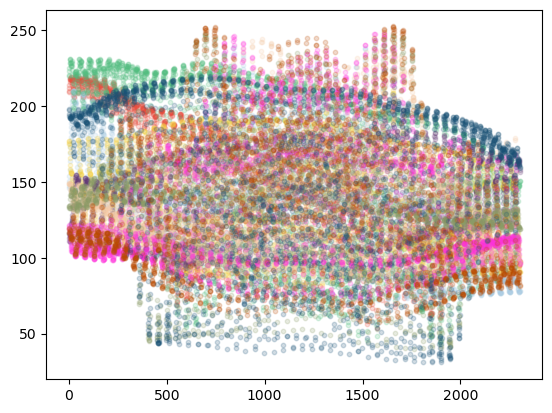

In [174]:
x_data = [i for i in range(2304)]
plt.scatter(x_data,kmeans_1.cluster_centers_[0], color = '#E74C3C',alpha=0.2,s=10)
plt.scatter(x_data,kmeans_1.cluster_centers_[1] , color = '#A9CCE3',alpha=0.2,s=10)
plt.scatter(x_data,kmeans_1.cluster_centers_[2], color = '#52BE80',alpha=0.2,s=10)
plt.scatter(x_data,kmeans_1.cluster_centers_[3] , color = '#F4D03F',alpha=0.2,s=10)
plt.scatter(x_data,kmeans_1.cluster_centers_[4], color = '#633974',alpha=0.2,s=10)
plt.scatter(x_data,kmeans_1.cluster_centers_[5] , color = '#F5CBA7',alpha=0.2,s=10)
plt.scatter(x_data,kmeans_1.cluster_centers_[6], color = '#FF33DD',alpha=0.2,s=10)
plt.scatter(x_data,kmeans_1.cluster_centers_[7] , color = '#8A9B66',alpha=0.2,s=10)
plt.scatter(x_data,kmeans_1.cluster_centers_[8], color = '#BA4A00',alpha=0.2,s=10)
plt.scatter(x_data,kmeans_1.cluster_centers_[9] , color = '#1A5276',alpha=0.2,s=10)

# Inertia

In [131]:
kmeans_1.inertia_

63708508010.16761

# Score

In [132]:
kmeans_1.score(X_train)

-63708508010.16761

# Elbow method

In [133]:
from sklearn.cluster import KMeans
inertias = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train)
    inertias.append(kmeans.inertia_)


D:\Applications\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Applications\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Applications\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Applications\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

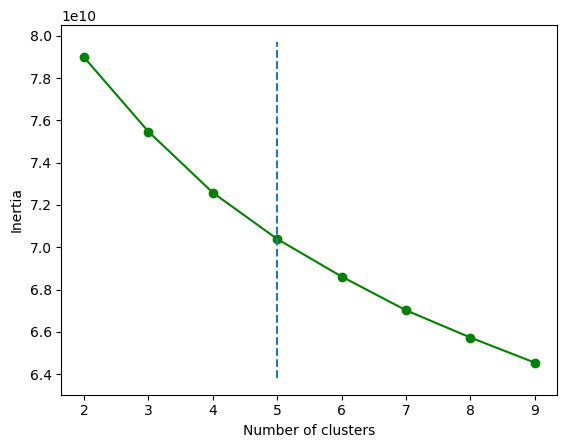

In [134]:
plt.plot(range(2,10), inertias, "o-g")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.vlines(5, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

6 is the optimal number of clusters

# Silhouette Scores

The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster

In [135]:
silhouette_score(X_train, kmeans.labels_) #computes the overall silhouette score

0.061389084878403555

In [136]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_train)
                for k in range(2, 11)]

D:\Applications\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Applications\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Applications\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Applications\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

In [137]:
silhouette_scores = [silhouette_score(X_train, model.labels_)
                     for model in kmeans_per_k[0:]]   

In [138]:
silhouette_scores

[0.16548658975058328,
 0.11754928831744602,
 0.0653964273287528,
 0.06545368165577067,
 0.06875063981273391,
 0.059105250237521056,
 0.06348686291364627,
 0.06153276221821876,
 0.05941547821635754]

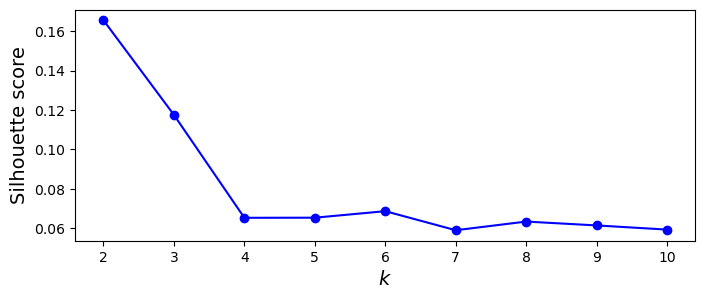

In [139]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 11), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
#save_fig("silhouette_score_vs_k_plot")
plt.show()

D:\Applications\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 2 The average silhouette_score is : 0.16548658975058328


D:\Applications\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 3 The average silhouette_score is : 0.11718618523560376


D:\Applications\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 4 The average silhouette_score is : 0.0653964273287528


D:\Applications\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 5 The average silhouette_score is : 0.060325066148021425


D:\Applications\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 6 The average silhouette_score is : 0.06976723417005666


D:\Applications\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 7 The average silhouette_score is : 0.059117889816694955


D:\Applications\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 8 The average silhouette_score is : 0.06393619070417647


D:\Applications\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 9 The average silhouette_score is : 0.061646768275162904


D:\Applications\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 10 The average silhouette_score is : 0.05921462392496291


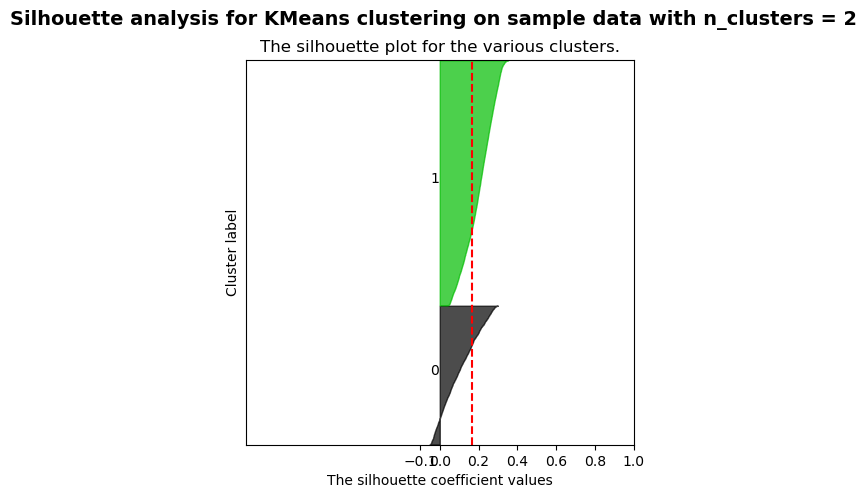

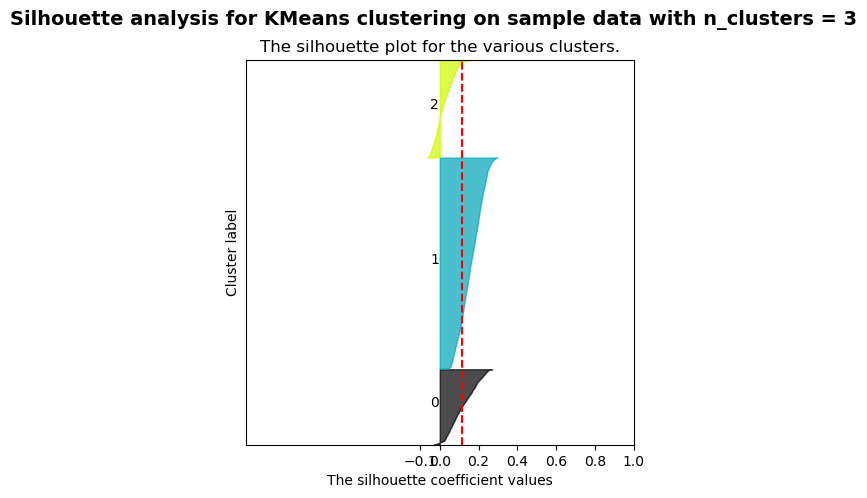

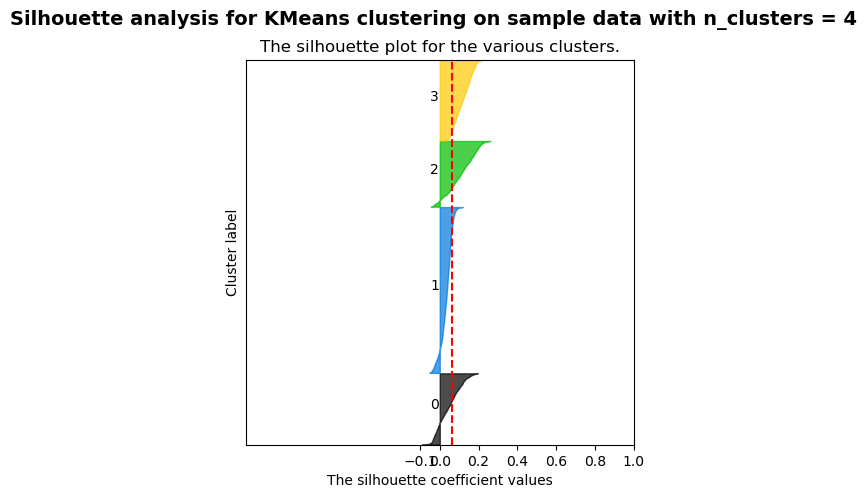

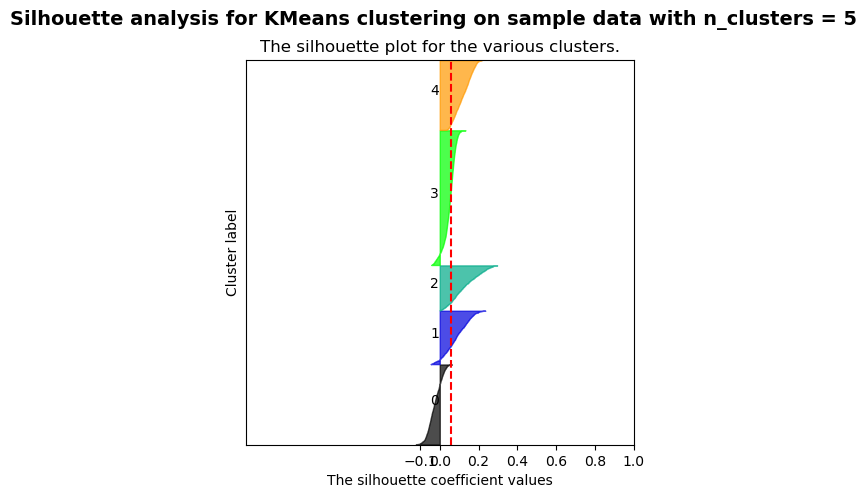

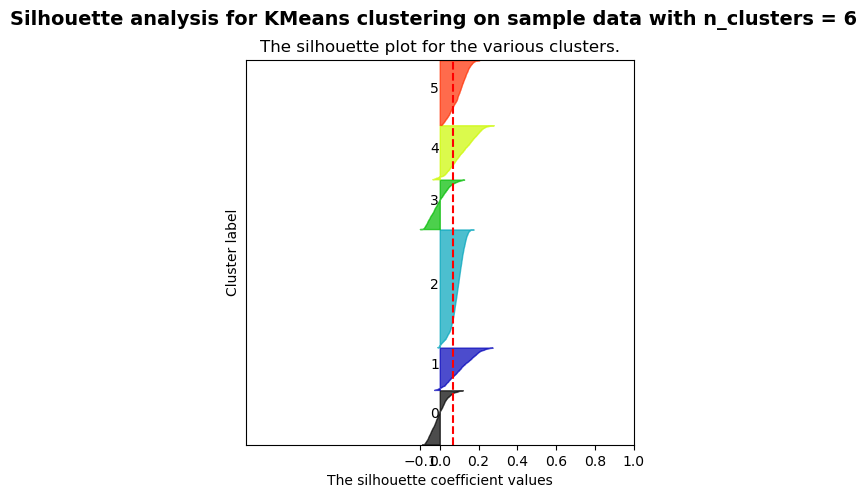

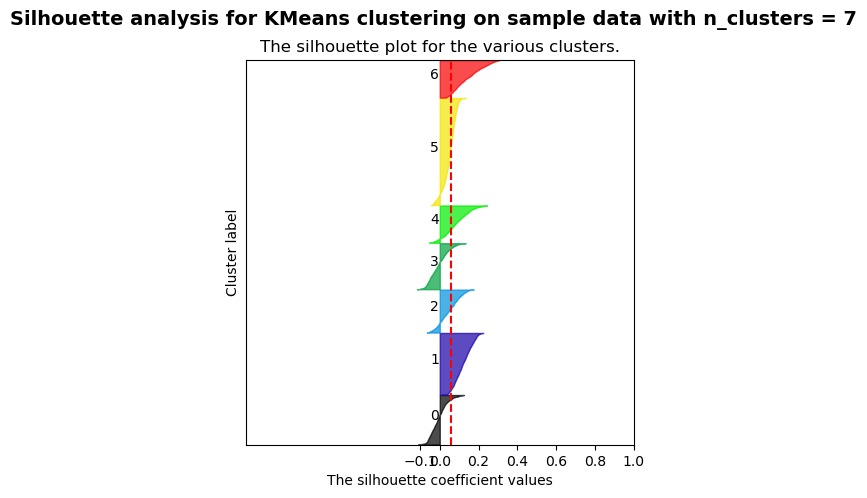

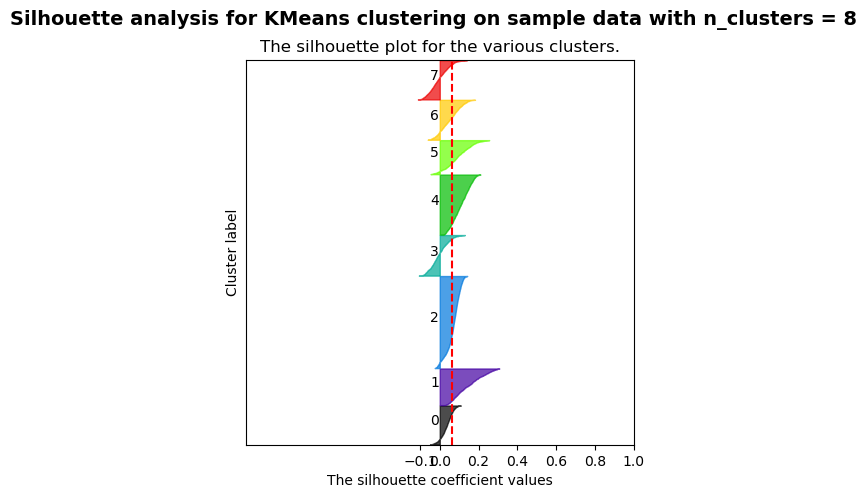

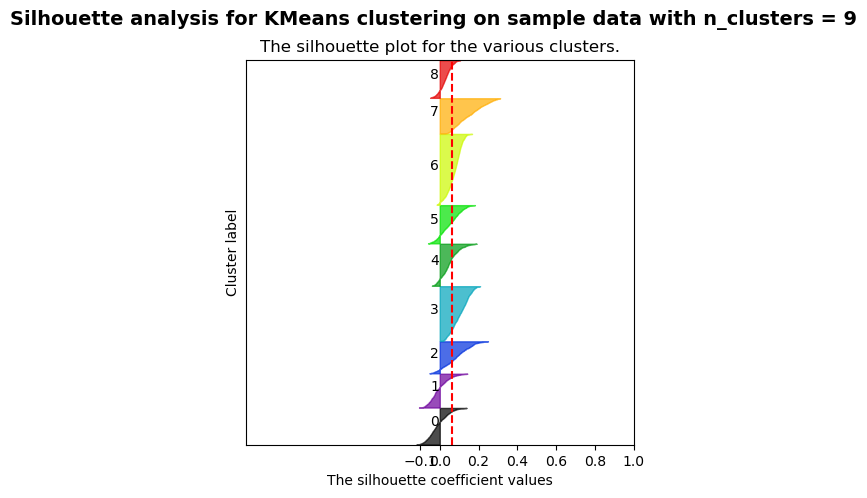

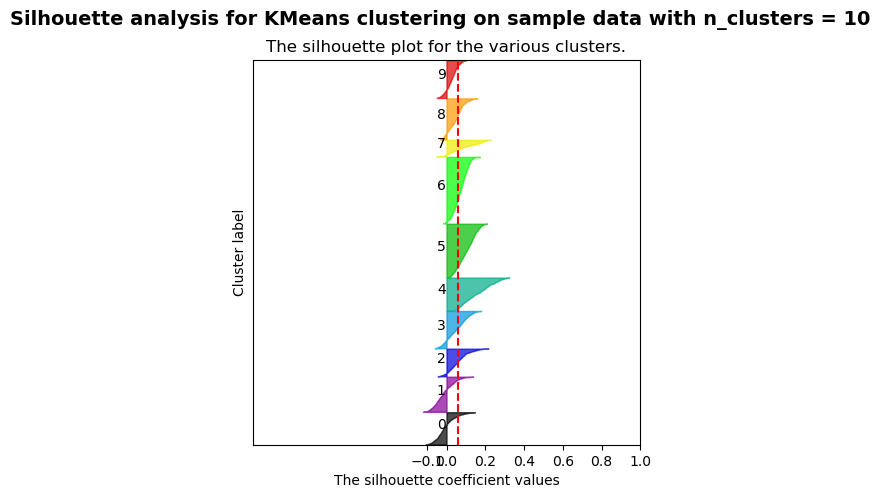

In [140]:

for n_clusters in range(2, 11):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(5, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_train) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_train)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_train, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_train, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

# Gaussian Mixture

In [141]:
gmm = GaussianMixture(n_components=10, covariance_type='full', random_state=42)
gmm.fit(X_train)

GaussianMixture(n_components=10, random_state=42)

In [142]:
labels_gmm = gmm.predict(X_train)
labels_gmm

array([2, 2, 0, ..., 7, 7, 1], dtype=int64)

# Showing the classes belonging to each cluster

In [143]:
image_cluster_2 = pd.DataFrame(y_train, columns=['Class'])
image_cluster_2['clusterid'] = labels_gmm
image_cluster_2

,Class,clusterid
0,0,2
1,0,2
2,0,0
3,0,0
4,0,0
...,...,...
9685,9,7
9686,9,7
9687,9,7
9688,9,7


In [144]:
mapping_cluster_to_classes(10, image_cluster_2, cols, clusterLabels)

data 

           Class 0  Class 1  Class 2  Class 3  Class 4  Class 5  Class 6  \
Cluster 0       20      196      198       98      210        0        0   
Cluster 1       38      257      158       60       63        2       11   
Cluster 2        6       26       18       18       17      181      158   
Cluster 3       60      264      141      202      123        0        0   
Cluster 4       17      354      758      309      802        2        7   
Cluster 5        0       41       55      214       37        5       76   
Cluster 6       22      410      210       99      150        0        0   
Cluster 7        1      137      107      168      157        8       34   
Cluster 8       25      380      443      156      332        0        0   
Cluster 9       21      155      162       86       89       12       74   

           Class 7  Class 8  Class 9  
Cluster 0        0        0        1  
Cluster 1        7       48        8  
Cluster 2      174      276      144  


# Silhouette Scores

In [145]:
silhouette_score(X_train, labels_gmm) #computes the overall silhouette score

0.06288706299508393

In [146]:
models_1 = GaussianMixture(n_components=2, covariance_type='full', random_state=42).fit(X_train)

In [147]:
models_2 = GaussianMixture(n_components=3, covariance_type='full', random_state=42).fit(X_train)

In [148]:
models_3 = GaussianMixture(n_components=4, covariance_type='full', random_state=42).fit(X_train)

In [149]:
models_4 = GaussianMixture(n_components=5, covariance_type='full', random_state=42).fit(X_train)

In [150]:
models_5 = GaussianMixture(n_components=6, covariance_type='full', random_state=42).fit(X_train)

In [151]:
models_6 = GaussianMixture(n_components=7, covariance_type='full', random_state=42).fit(X_train)

In [152]:
models_7 = GaussianMixture(n_components=8, covariance_type='full', random_state=42).fit(X_train)

In [153]:
models_8 = GaussianMixture(n_components=9, covariance_type='full', random_state=42).fit(X_train)

In [154]:
models_9 = GaussianMixture(n_components=10, covariance_type='full', random_state=42).fit(X_train)

In [155]:
models_10 = GaussianMixture(n_components=11, covariance_type='full', random_state=42).fit(X_train)

In [156]:
models_11 = GaussianMixture(n_components=12, covariance_type='full', random_state=42).fit(X_train)

In [157]:
models_12 = GaussianMixture(n_components=13, covariance_type='full', random_state=42).fit(X_train)

In [158]:
models_13 = GaussianMixture(n_components=14, covariance_type='full', random_state=42).fit(X_train)

In [159]:
models_14 = GaussianMixture(n_components=15, covariance_type='full', random_state=42).fit(X_train)

In [160]:
models = [models_1,models_2,models_3,models_4,models_5,models_6,models_7,models_8,models_9,models_10,models_11,models_12,models_13,models_14]

In [161]:
labels_1 = models_1.predict(X_train)
labels_2 = models_2.predict(X_train)
labels_3 = models_3.predict(X_train)
labels_4 = models_4.predict(X_train)
labels_5 = models_5.predict(X_train)
labels_6 = models_6.predict(X_train)
labels_7 = models_7.predict(X_train)
labels_8 = models_8.predict(X_train)
labels_9 = models_9.predict(X_train)
labels_10 = models_10.predict(X_train)
labels_11 = models_11.predict(X_train)
labels_12 = models_12.predict(X_train)
labels_13 = models_13.predict(X_train)
labels_14 = models_14.predict(X_train)


In [162]:
silhouette_score_1 = silhouette_score(X_train, labels_1)
silhouette_score_2 = silhouette_score(X_train, labels_2)                    
silhouette_score_3 = silhouette_score(X_train, labels_3)
silhouette_score_4 = silhouette_score(X_train, labels_4)
silhouette_score_5 = silhouette_score(X_train, labels_5)                    
silhouette_score_6 = silhouette_score(X_train, labels_6)
silhouette_score_7 = silhouette_score(X_train, labels_7)
silhouette_score_8 = silhouette_score(X_train, labels_8)                    
silhouette_score_9 = silhouette_score(X_train, labels_9)
silhouette_score_10 = silhouette_score(X_train, labels_10)
silhouette_score_11 = silhouette_score(X_train, labels_11)                    
silhouette_score_12 = silhouette_score(X_train, labels_12)
silhouette_score_13 = silhouette_score(X_train, labels_13)
silhouette_score_14 = silhouette_score(X_train, labels_14)                    


In [163]:
silhouette_scores_gmm = [silhouette_score_1,silhouette_score_2,silhouette_score_3,silhouette_score_4,
                     silhouette_score_5,
                     silhouette_score_6,silhouette_score_7,silhouette_score_8,silhouette_score_9,
                     silhouette_score_10,silhouette_score_11,silhouette_score_12,
                     silhouette_score_13,silhouette_score_14
                    ]

In [164]:
silhouette_scores_gmm

[0.1653172539818582,
 0.11749987537149836,
 0.06558166284114676,
 0.06545368165577067,
 0.0692311867935299,
 0.059105250237521056,
 0.059528960114322634,
 0.05639619721162049,
 0.06288706299508393,
 0.0567482448845152,
 0.05016596575370072,
 0.04655850430559869,
 0.045660137659645564,
 0.04954824498288899]

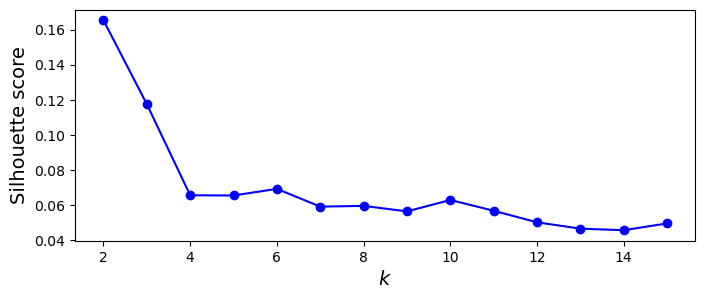

In [165]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 16), silhouette_scores_gmm, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# AIC vs BIC

Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) are both model selection criteria that are used to compare different models and choose the one that best fits the data.
AIC is based on the maximum likelihood principle, and it penalizes models with a large number of parameters relative to the size of the data. 
BIC is similar to AIC, but it penalizes models with a larger number of parameters more severely. 


In [167]:
bic_1 = models_1.bic(X_train)
bic_2 = models_2.bic(X_train)
bic_3 = models_3.bic(X_train)
bic_4 = models_4.bic(X_train)
bic_5 = models_5.bic(X_train)
bic_6 = models_6.bic(X_train)
bic_7 = models_7.bic(X_train)
bic_8 = models_8.bic(X_train)
bic_9 = models_9.bic(X_train)
bic_10 = models_10.bic(X_train)
bic_11 = models_11.bic(X_train)
bic_12 = models_12.bic(X_train)
bic_13 = models_13.bic(X_train)
bic_14 = models_14.bic(X_train)

In [168]:
bic_arr = [bic_1,bic_2,bic_3,bic_4,bic_5,bic_6,bic_7,bic_8,bic_9,bic_10,bic_11,bic_12,bic_13,bic_14]

In [169]:
aic_1 = models_1.aic(X_train)
aic_2 = models_2.aic(X_train)
aic_3 = models_3.aic(X_train)
aic_4 = models_4.aic(X_train)
aic_5 = models_5.aic(X_train)
aic_6 = models_6.aic(X_train)
aic_7 = models_7.aic(X_train)
aic_8 = models_8.aic(X_train)
aic_9 = models_9.aic(X_train)
aic_10 = models_10.aic(X_train)
aic_11 = models_11.aic(X_train)
aic_12 = models_12.aic(X_train)
aic_13 = models_13.aic(X_train)
aic_14 = models_14.aic(X_train)

In [170]:
aic_arr = [aic_1,aic_2,aic_3,aic_4,aic_5,aic_6,aic_7,aic_8,aic_9,aic_10,aic_11,aic_12,aic_13,aic_14]

In [171]:
n_components = np.arange(2, 16)

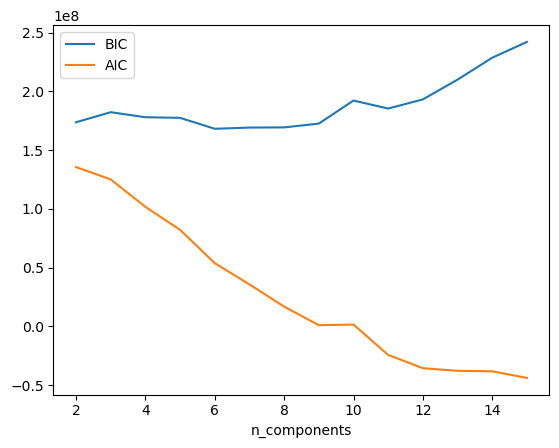

In [172]:
plt.plot(n_components, bic_arr, label='BIC')
plt.plot(n_components, aic_arr, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In our case we see that AIC and BIC give very different model selections. The AIC is better suited to model selection for prediction as it is asymptotically equivalent to leave-one-out cross-validation in regression, or one-step-cross-validation in time series. On the other hand, it might be argued that the BIC is better suited to model selection for explanation, as it is consistent.

Hence we will use the AIC since we are looking for a good predictive model

The optimal number of clusters is the value that minimizes the AIC. The AIC tells us that around 10-12 clusters would have been a better choice. 
